In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nuthangowda","key":"3b15e291dc050f84ec9c5720fcfc2df8"}'}

In [2]:
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download soumikrakshit/anime-faces

 98% 433M/441M [00:03<00:00, 174MB/s]
100% 441M/441M [00:03<00:00, 136MB/s]


In [4]:
!unzip /content/anime-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.png       

In [5]:
import os
import random
import torch
import torch.nn as nn 
import torch.nn.parallel
import torch.optim as optim 
import torch.utils.data 
import torchvision.datasets as dset 
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

In [6]:
manual_seed = 999
print("Random_seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random_seed:  999


In [23]:
dataroot = "/content/data"
#number of workers for dataloaders
workers =2 
#batch size during training
batch_size = 128*2

#Spatial size of training images. ALl images will be resized to this
#size using a transformer/
image_size = 64

#number of channers in the training images. for color images this is 3
nc = 3
#size of z latent vector (i.e size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
#size of feature maps in dicriminator
ndf = 64
#number of training epochs
num_epochs = 100
#leaning rate for optimizers
lr = 0.0005
#beta1 hyperparam for ADAM optimizer
beta1 = 0.5
#number of gpu available. USE 0 for cpu mode
ngpu = 1

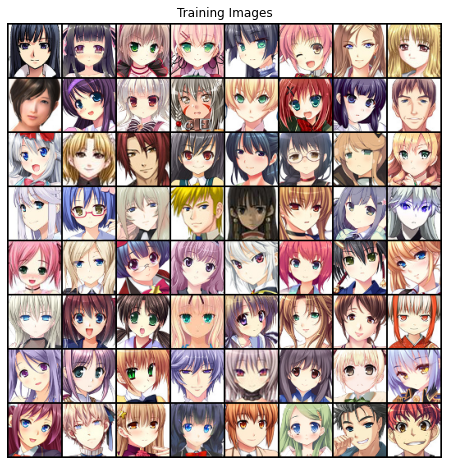

In [24]:
dataset = dset.ImageFolder(root=dataroot, 
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5, 0.5)),
]))
#Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0) else "cpu")

#plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

In [25]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [26]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
        

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [27]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

  # Create the Discriminator
netD = Discriminator(ngpu).to(device)

    # Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [28]:
#initialize BCEloss function
criterion = nn.BCELoss()

#create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#establish convention for real and fake labels during training 
real_label = 1.
fake_label = 0.

#setup adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Generator's state_dict: ")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())
print("\nDiscriminator's state_dict:")
for param_tensor in netD.state_dict():
    print(param_tensor, "\t", netD.state_dict()[param_tensor].size())

Generator's state_dict: 
main.0.weight 	 torch.Size([100, 512, 4, 4])
main.1.weight 	 torch.Size([512])
main.1.bias 	 torch.Size([512])
main.1.running_mean 	 torch.Size([512])
main.1.running_var 	 torch.Size([512])
main.1.num_batches_tracked 	 torch.Size([])
main.3.weight 	 torch.Size([512, 256, 4, 4])
main.4.weight 	 torch.Size([256])
main.4.bias 	 torch.Size([256])
main.4.running_mean 	 torch.Size([256])
main.4.running_var 	 torch.Size([256])
main.4.num_batches_tracked 	 torch.Size([])
main.6.weight 	 torch.Size([256, 128, 4, 4])
main.7.weight 	 torch.Size([128])
main.7.bias 	 torch.Size([128])
main.7.running_mean 	 torch.Size([128])
main.7.running_var 	 torch.Size([128])
main.7.num_batches_tracked 	 torch.Size([])
main.9.weight 	 torch.Size([128, 64, 4, 4])
main.10.weight 	 torch.Size([64])
main.10.bias 	 torch.Size([64])
main.10.running_mean 	 torch.Size([64])
main.10.running_var 	 torch.Size([64])
main.10.num_batches_tracked 	 torch.Size([])
main.12.weight 	 torch.Size([64, 3, 4, 

In [29]:
#training loop

#list to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs+1):
    for i, data in enumerate(dataloader,0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        #forward pass real batch through D
        output = netD(real_cpu).view(-1)
        #calculate loss on all-real batch
        errD_real = criterion(output, label)
        #calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        ##train with all-fake batch
        #generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        #generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #classify all fake images batch with dD
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
         # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if epoch % 25 == 0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': netG.state_dict(),
                'optimizer_state_dict': optimizerG.state_dict(),
                'loss': G_losses,
                }, 'generator100.pt')
        torch.save({
                'epoch': epoch,
                'model_state_dict': netD.state_dict(),
                'optimizer_state_dict': optimizerD.state_dict(),
                'loss': D_losses,
                }, 'discriminator100.pt')

Starting Training Loop...
[0/100][0/22]	Loss_D: 1.6668	Loss_G: 5.6520	D(x): 0.6966	D(G(z)): 0.6459 / 0.0068
[1/100][0/22]	Loss_D: 0.1198	Loss_G: 10.4202	D(x): 0.9659	D(G(z)): 0.0534 / 0.0001
[2/100][0/22]	Loss_D: 0.9437	Loss_G: 10.3227	D(x): 0.6558	D(G(z)): 0.0083 / 0.0004
[3/100][0/22]	Loss_D: 0.6615	Loss_G: 6.3154	D(x): 0.7395	D(G(z)): 0.1192 / 0.0114
[4/100][0/22]	Loss_D: 0.3727	Loss_G: 4.1452	D(x): 0.8621	D(G(z)): 0.0876 / 0.0354
[5/100][0/22]	Loss_D: 0.8980	Loss_G: 7.1256	D(x): 0.9196	D(G(z)): 0.4844 / 0.0021
[6/100][0/22]	Loss_D: 1.1381	Loss_G: 10.6179	D(x): 0.8580	D(G(z)): 0.5439 / 0.0001
[7/100][0/22]	Loss_D: 0.9377	Loss_G: 6.5870	D(x): 0.7830	D(G(z)): 0.3909 / 0.0041
[8/100][0/22]	Loss_D: 0.6448	Loss_G: 4.5301	D(x): 0.6725	D(G(z)): 0.0583 / 0.0208
[9/100][0/22]	Loss_D: 0.6225	Loss_G: 5.6498	D(x): 0.7937	D(G(z)): 0.2170 / 0.0070
[10/100][0/22]	Loss_D: 0.7163	Loss_G: 3.3649	D(x): 0.6166	D(G(z)): 0.0656 / 0.0524
[11/100][0/22]	Loss_D: 0.6695	Loss_G: 5.9794	D(x): 0.8002	D(G(z)): 0

KeyboardInterrupt: ignored

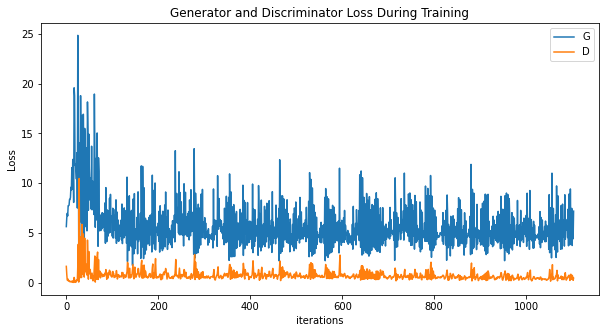

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

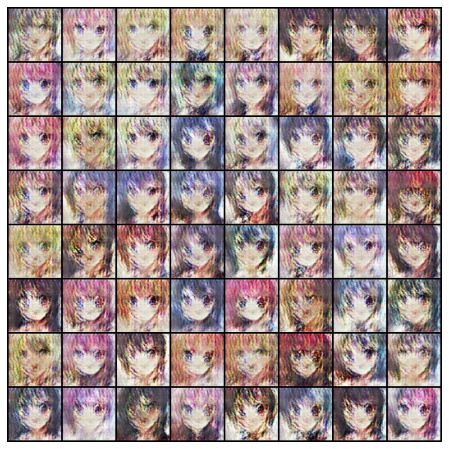

In [31]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

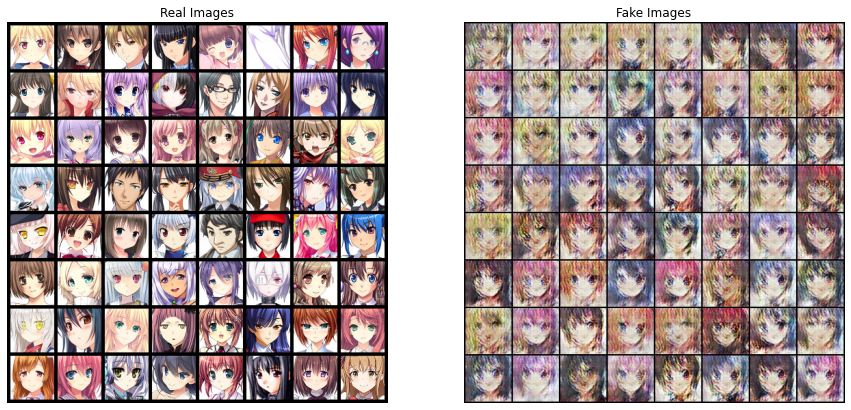

In [32]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [33]:
from torchvision.utils import save_image
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')
print("Done")

Done
